# Simulation of Domain Walls and Cosmic Strings #

In [19]:
"""
------------------
Standard libraries
------------------
"""
from typing import Optional

"""
------------------
External libraries
------------------
"""
from matplotlib import cm
from matplotlib import pyplot as plt
import numpy as np
from numba import jit
from tqdm.notebook import tqdm

In [2]:
"""
-----------------------------------
JIT-compiled computation functions.
-----------------------------------
"""


def laplacian2D(phi: np.ndarray, dx: float, N: int, fast: bool = False) -> np.ndarray:
    """
    Computes the Laplacian of a square discrete 2D scalar field `phi` given a spacing `dx` and size `N`. This is done
    to a fourth-order approximation. The computation can either be done iteratively or through array operations.
    
    Parameters
    ----------
    phi : np.ndarray
        a square discrete 2D scalar field to compute the Laplacian of.
    dx : float
        the spacing between points of the field `phi`.
    N : int
        the size of the field `phi`.
    fast : bool
        if `True` the computation will be carried out using array operations which are faster but requires more memory otherwise
        if `False` the computation will be done iteratively which is slower but less memory intensive.
    
    Returns
    -------
    ddphi : np.ndarray
        the Laplacian of the field `phi` to a fourth-order approximation.
    """

    if fast:
        return laplacian2D_matrix(phi, dx, N)
    else:
        return laplacian2D_iterative(phi, dx, N)


@jit(nopython=True)
def laplacian2D_iterative(phi: np.ndarray, dx: float, N: int) -> np.ndarray:
    """
    Computes the Laplacian of a square discrete 2D scalar field `phi` given a spacing `dx` and size `N`. This is done
    to a fourth-order approximation. The computation is done iteratively per cell.
    
    Parameters
    ----------
    phi : np.ndarray
        a square discrete 2D scalar field to compute the Laplacian of.
    dx : float
        the spacing between points of the field `phi`.
    N : int
        the size of the field `phi`.
    
    Returns
    -------
    ddphi : np.ndarray
        the Laplacian of the field `phi` to a fourth-order approximation.
    """

    # Initialise the Laplacian array.
    ddphi = np.zeros(shape=(N, N))

    for i in range(0, N):
        for j in range(0, N):
            ddphi[i, j] = 1 / (12.0 * dx**2.0)\
                * (\
                    - phi[np.mod(i + 2, N), j] + 16.0 * phi[np.mod(i + 1, N), j] + 16.0 * phi[i - 1, j] - phi[i - 2, j]\
                    - phi[i, np.mod(j + 2, N)] + 16.0 * phi[i, np.mod(j + 1, N)] + 16.0 * phi[i, j - 1] - phi[i, j - 2]\
                    - 60.0 * phi[i, j]
                )

    return ddphi


@jit(nopython=True)
def laplacian2D_matrix(phi: np.ndarray, dx: float, _N: int) -> np.ndarray:
    """
    Computes the Laplacian of a square discrete 2D scalar field `phi` given a spacing `dx` and size `N`. This is done
    to a fourth-order approximation. The computation is done via array operations.
    
    Parameters
    ----------
    phi : np.ndarray
        a square discrete 2D scalar field to compute the Laplacian of.
    dx : float
        the spacing between points of the field `phi`.
    N : int
        the size of the field `phi`.
    
    Returns
    -------
    ddphi : np.ndarray
        the Laplacian of the field `phi` to a fourth-order approximation.
    """
    phi_i_add1 = np.roll(phi, -1, 0)
    phi_i_min1 = np.roll(phi, +1, 0)
    phi_i_add2 = np.roll(phi, -2, 0)
    phi_i_min2 = np.roll(phi, +2, 0)
    phi_j_add1 = np.roll(phi, -1, 1)
    phi_j_min1 = np.roll(phi, +1, 1)
    phi_j_add2 = np.roll(phi, -2, 1)
    phi_j_min2 = np.roll(phi, +2, 1)

    ddphi = 1 / (12.0 * dx**2.0)\
        * (\
            - phi_i_add2 + 16.0 * phi_i_add1 + 16.0 * phi_i_min1 - phi_i_min2\
            - phi_j_add2 + 16.0 * phi_j_add1 + 16.0 * phi_j_min1 - phi_j_min2\
            - 60.0 * phi
    )

    return ddphi

In [3]:
"""
---------------------
Model Parameters
---------------------
"""
# PRS trick parameter
alpha = 2
# Cosmological era
era = 1 
# Width of domain wall (lambda = 2*pi^2/w^2)
w = 5

"""
-------------------------
Discretisation Parameters
-------------------------
"""
# Size of the simulation grid
N = 1000
# Spacing between grid points
dx = 1.0
# Time interval
dt = 0.1

In [4]:
"""
-------------------------
Field Evolution Equations
-------------------------
"""


def evolve_phi(phi: np.ndarray, phidot: np.ndarray, phidotdot: np.ndarray, dt: float) -> np.ndarray:
    """
    Evolves the field `phi`.
    
    Parameters
    ----------
    phi : np.ndarray
        the field to evolve.
    phidot : np.ndarray
        the 'velocity' of the field.
    phidotdot : np.ndarray
        the 'acceleration' of the field.
    dt : float
        the time interval used.
    
    Returns
    -------
    evolved_phi : np.ndarray
        the evolved field.
    """
    return phi + dt * (phidot + 0.5 * phidotdot * dt)


def evolve_phidot(phidot: np.ndarray, current_phidotdot: np.ndarray, next_phidotdot: np.ndarray, dt: float) -> np.ndarray:
    """
    Evolves the 'velocity' of the field `phi`. This is done after the field `phi` has been evolved to the next timestep.
    
    Parameters
    ----------
    phidot : np.ndarray
        the 'velocity' of the field to evolve.
    current_phidotdot : np.ndarray
        the current 'acceleration' of the field.
    next_phidotdot : np.ndarray
        the 'acceleration' of the evolved field.
    dt : float
        the time interval used.
    
    Returns
    -------
    evolved_phidot : np.ndarray
        the evolved 'velocity' of the field.
    """
    return phidot + 0.5 * (current_phidotdot + next_phidotdot) * dt


def evolve_phidotdot_dw(phi, phidot, alpha, era, w, N, dx, t) -> np.ndarray:
    """
    Evolves the 'acceleration' of the field `phi`. This is done after the field `phi` has been evolved to the next timestep but
    before the 'velocity' of the field `phidot` has been evolved. This is because the current 'acceleration' and the evolved
    'acceleration' are both required to evolve the 'velocity'. This is for domain wall simulations.
    
    Parameters
    ----------
    phi : np.ndarray
        the field to evolve.
    phidot : np.ndarray
        the 'velocity' of the field.
    alpha : float
        a 'trick' parameter necessary in the PRS algorithm.
    era : float
        the cosmological era.
    w : float
        the width of the domain walls. Relates to the parameter `lambda` by the equation lambda = 2*pi^2/w^2.
    N : int
        the size of the field.
    dx : float
        the spacing between field grid points.
    t : float
        the current time.
    
    Returns
    -------
    evolved_phi : np.ndarray
        the evolved field.
    """
    return laplacian2D(phi, dx, N) - (2 * np.pi**2.0 / w**2.0) * (phi**2.0 - 1) * phi - alpha * (era/t) * phidot

In [5]:
def run_domain_wall_simulation(
    N: int,
    dx: float,
    dt: float,
    alpha: float,
    era: float,
    w: float,
    seed: Optional[int],
    run_time: Optional[int]
):
    """
    Runs a domain wall simulation in two dimensions.
    
    Parameters
    ----------
    N : int
        the size of the field to simulate.
    dx : float
        the spacing between grid points.
    dt : float
        the time interval between timesteps.
    alpha : float
        the 'trick' parameter used in the PRS algorithm. This should be equal to 2.
    era : float
        the cosmological era.
    w : float
        the width of the domain walls.
    seed : Optional[int]
        the seed used in generation of the initial state of the field. If `None` the seed will be chosen by numpy's `seed` function.
    run_time : Optional[int]
        the number of timesteps simulated. If `None` the number of timesteps used will be the light crossing time.
    """
    # Clock
    t = 1.0 * dt
    
    # Seed the RNG
    if seed is not None:
        np.random.seed(seed)
    else:
        np.random.seed()

    # Initialise field
    phi = 0.1 * np.random.normal(size=(N, N))
    phidot = np.zeros(shape=(N, N))
    phidotdot = evolve_phidotdot_dw(phi, phidot, alpha, era, w, N, dx, t)

    # Set run time of simulation to light crossing time if no specific time is given
    if run_time is None:
        run_time = int(0.5 * N * dx/dt)

    # Figure setup
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.ion()
    fig.show()
    fig.canvas.draw()
    
    # Run loop
    for i in tqdm(range(run_time)):
        # Evolve phi
        phi = evolve_phi(phi, phidot, phidotdot, dt)

        # Next timestep
        t = t + dt
        
        next_phidotdot = evolve_phidotdot_dw(phi, phidot, alpha, era, w, N, dx, t)
        # Evolve phidot
        phidot = evolve_phidot(phidot, phidotdot, next_phidotdot, dt)
        
        # Evolve phidotdot
        phidotdot = next_phidotdot

        ax.clear()
        # vmin, vmax give the min and max values of phi corresponding to the colormap
        ax.imshow(phi, vmin=-1.1, vmax=1.1)
        fig.canvas.draw()

<IPython.core.display.Javascript object>


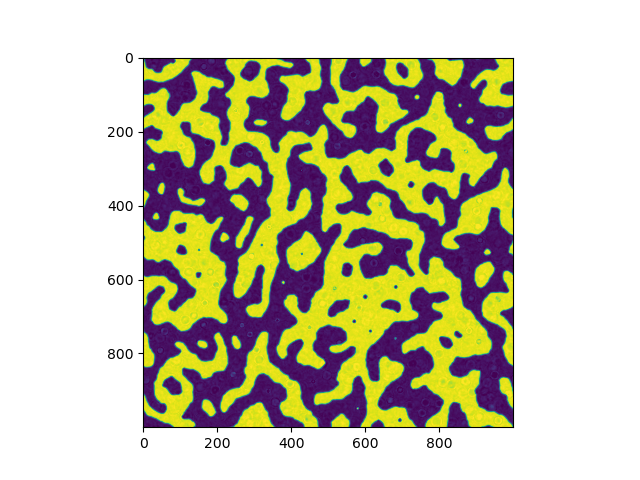

  0%|          | 0/500 [00:00<?, ?it/s]

In [6]:
%matplotlib notebook

# Domain wall simulation
run_domain_wall_simulation(
    N, dx, dt, alpha, era, w, None, 500
)

In [7]:
def evolve_phidotdot_cs(phi_target, phidot_target, phi_other, alpha, era, w, N, dx, t) -> np.ndarray:
    """
    Evolves the 'acceleration' of the field `phi`. This is done after the field `phi` has been evolved to the next timestep but
    before the 'velocity' of the field `phidot` has been evolved. This is because the current 'acceleration' and the evolved
    'acceleration' are both required to evolve the 'velocity'. This is for domain wall simulations.
    
    Parameters
    ----------
    phi_real : np.ndarray
        the component of the field to evolve.
    phidot_real : np.ndarray
        the 'velocity' of the component of the field to evolve.
    phi_other : np.ndarray
        the other component of the field.
    alpha : float
        a 'trick' parameter necessary in the PRS algorithm.
    era : float
        the cosmological era.
    w : float
        the width of the domain walls. Relates to the parameter `lambda` by the equation lambda = 2*pi^2/w^2.
    N : int
        the size of the field.
    dx : float
        the spacing between field grid points.
    t : float
        the current time.
    
    Returns
    -------
    evolved_phi : np.ndarray
        the evolved field.
    """
    return laplacian2D(phi_target, dx, N) - (2 * np.pi**2.0 / w**2.0) * (phi_target**2.0 + phi_other**2.0 - 1) * phi_target - alpha * (era/t) * phidot_target

In [28]:
def run_cosmic_string_simulation(
    N: int,
    dx: float,
    dt: float,
    alpha: float,
    era: float,
    w: float,
    seed: Optional[int],
    run_time: Optional[int]
):
    """
    Runs a cosmic string simulation in two dimensions.
    
    Parameters
    ----------
    N : int
        the size of the field to simulate.
    dx : float
        the spacing between grid points.
    dt : float
        the time interval between timesteps.
    alpha : float
        the 'trick' parameter used in the PRS algorithm. This should be equal to 2.
    era : float
        the cosmological era.
    w : float
        the width of the domain walls.
    seed : Optional[int]
        the seed used in generation of the initial state of the field. If `None` the seed will be chosen by numpy's `seed` function.
    run_time : Optional[int]
        the number of timesteps simulated. If `None` the number of timesteps used will be the light crossing time.
    """
    # Clock
    t = 1.0 * dt
    
    # Seed the RNG
    if seed is not None:
        np.random.seed(seed)
    else:
        np.random.seed()

    # Initialise real field
    phi_real = 0.1 * np.random.normal(size=(N, N))
    phidot_real = np.zeros(shape=(N, N))
    
    # Initialise imaginary field
    phi_imaginary = 0.1 * np.random.normal(size=(N, N))
    phidot_imaginary = np.zeros(shape=(N, N))
    
    # Coupled terms
    phidotdot_real = evolve_phidotdot_cs(phi_real, phidot_real, phi_imaginary, alpha, era, w, N, dx, t)
    phidotdot_imaginary = evolve_phidotdot_cs(phi_imaginary, phidot_imaginary, phi_real, alpha, era, w, N, dx, t)
    
    
    # Set run time of simulation to light crossing time if no specific time is given
    if run_time is None:
        run_time = int(0.5 * N * dx/dt)

    # Figure setup
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    plt.ion()
    fig.show()
    ax.clear()
    pos = ax.imshow(np.arctan2(phi_imaginary, phi_real), vmin=-np.pi, vmax=np.pi, cmap="twilight_shifted")
    fig.canvas.draw()
    
    plt.colorbar(pos)
    # Run loop
    for i in tqdm(range(run_time)):
        # Evolve phi
        phi_real = evolve_phi(phi_real, phidot_real, phidotdot_real, dt)
        phi_imaginary = evolve_phi(phi_imaginary, phidot_imaginary, phidotdot_imaginary, dt)

        # Next timestep
        t = t + dt
        
        next_phidotdot_real = evolve_phidotdot_cs(phi_real, phidot_real, phi_imaginary, alpha, era, w, N, dx, t)
        next_phidotdot_imaginary = evolve_phidotdot_cs(phi_imaginary, phidot_imaginary, phi_real, alpha, era, w, N, dx, t)
        # Evolve phidot
        phidot_real = evolve_phidot(phidot_real, phidotdot_real, next_phidotdot_real, dt)
        phidot_imaginary = evolve_phidot(phidot_imaginary, phidotdot_imaginary, next_phidotdot_imaginary, dt)
        
        # Evolve phidotdot
        phidotdot_real = next_phidotdot_real
        phidotdot_imaginary = next_phidotdot_imaginary

        ax.clear()
        # vmin, vmax give the min and max values of phi corresponding to the colormap
        ax.imshow(np.arctan2(phi_imaginary, phi_real), vmin=-np.pi, vmax=np.pi, cmap="twilight_shifted")
        fig.canvas.draw()

<IPython.core.display.Javascript object>


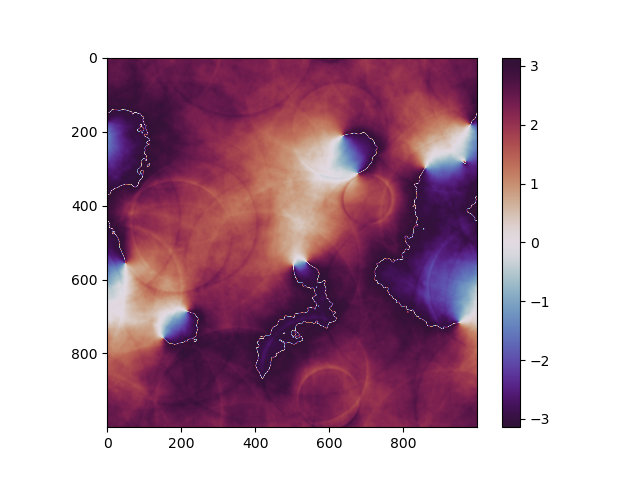

  0%|          | 0/5000 [00:00<?, ?it/s]

In [32]:
%matplotlib notebook

# Cosmic string simulation
run_cosmic_string_simulation(
    N, dx, dt, alpha, era, w, None, None
)